# Blobs and SIFT features

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

from lib import gaussianSmoothing, gaussian1DKernels

## Blob detector
We will use the Difference of Gaussian (DoG) method to detect blobs.

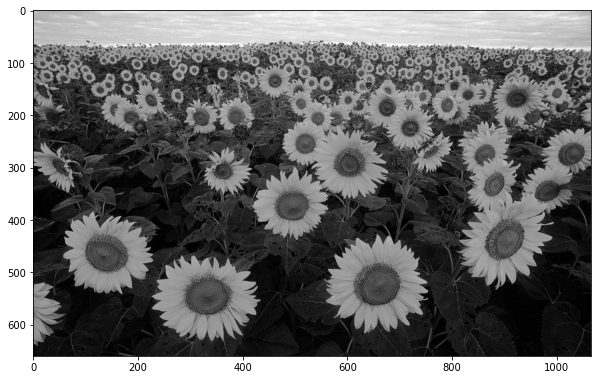

In [2]:
color_im = cv2.imread("data/sunflowers.jpg")[:, :, [2, 1, 0]]
im = np.sum(cv2.imread("data/sunflowers.jpg"), axis=2) / 3 / 255
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im, cmap="gray");

### 1. Scale pyramid of the image

In [3]:
def scaleSpaced(im, sigma, n):
    """
    Apply a Gaussian kernel of width sigma*2**i, i = 0, 1, ..., n − 1

    Parameters
    ----------
    im: np array
        Original image
    sigma: float
        width of the first gaussian kernel
    n: int
        number of images in the scale pyramid

    Return
    ------
    im_scales: n * I.shape array
        scale pyramid of the original image.
    """
    im, _, _ = gaussianSmoothing(im=im, sigma=sigma)
    im_scales = [im.copy()]
    for i in range(n):
        im, _, _ = gaussianSmoothing(im=im, sigma=sigma)
        im_scales.append(im.copy())
        sigma *= 2
    return np.array(im_scales)

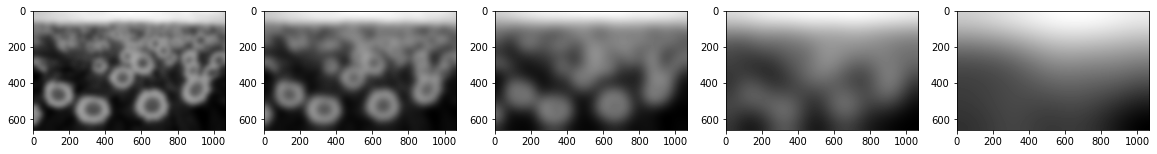

In [4]:
n=5
sigma=15

im_scales = scaleSpaced(im=im, sigma=sigma, n=n)
fig, ax=plt.subplots(1, n, figsize=(20, 5))
for i in range(n):
    ax[i].imshow(im_scales[i], cmap="gray")

### 2. Difference of Gaussians

$k=2^{\frac{1}{3}}$

In [5]:
def differenceOfGaussian(im, sigma, n):
    """
    Return the scale space DoG of the image
    
    Parameters
    ----------
    im: np array
        Original image
    sigma: float
        width of the first gaussian kernel
    n: int
        number of images in the scale pyramid
    Return
    ------
    DoG: (n - 1) * I.shape array
        scale space DoGs of the original image.
    """
    im_scales = scaleSpaced(im=im, sigma=sigma, n=n)
    DoGs = [im_scales[i + 1] - im_scales[i] for i in range(n - 1)]
    return np.array(DoGs)

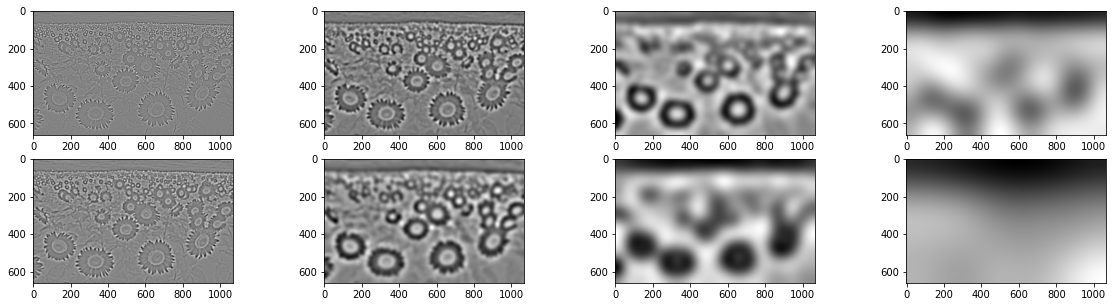

In [6]:
n=9
sigma=2
DoGs = differenceOfGaussian(im=im, sigma=sigma, n=n)


r = int(np.ceil((n - 1) / 2))
fig, ax=plt.subplots(2, r, figsize=(20, 5))
for i in range(n - 1):
    ax[i%2][i//2].imshow(DoGs[i], cmap="gray")

### 3. BLOBs

In [7]:
def detectBlobs(im, sigma, n, threshold, order=1):
    """
    Return blobs in the image.
    
    Parameters
    ----------
    im: np array
        Original image
    sigma: float
        width of the first gaussian kernel
    n: int
        number of images in the scale pyramid

    Return
    ------
    blobs:
        blobs (pixels) of the original image with a DoG larger than the
        threshold.
    """
    DoGs = np.abs(differenceOfGaussian(im=im, sigma=sigma, n=n))
    blobs = non_maximum_suppression(DoGs, order) > threshold
    return np.array(blobs)


def non_maximum_suppression(data, order=1):
    """Detects local maxima in a 3D array

    Parameters
    ---------
    data : 3d ndarray
    order : int
        How many points on each side to use for the comparison

    Returns
    -------
    coords : ndarray
        coordinates of the local maxima
    values : ndarray
        values of the local maxima
    """
    size = 1 + 2 * order
    footprint = np.ones((3, size, size))
    footprint[1, order, order] = 0
    filtered = scipy.ndimage.maximum_filter(data, footprint=footprint, mode="constant")
    mask_local_maxima = data > filtered
    data[~mask_local_maxima] = 0
    
    return data

In [11]:
sigma = 4
n = 6

blobs = detectBlobs(im, sigma, n, threshold=0.12, order=10)
centers = np.argwhere(blobs)[:, 1:]

DoGs = differenceOfGaussian(im=im, sigma=sigma, n=n)
radius= (2 ** np.argwhere(blobs)[:, 0] * sigma).astype(int)

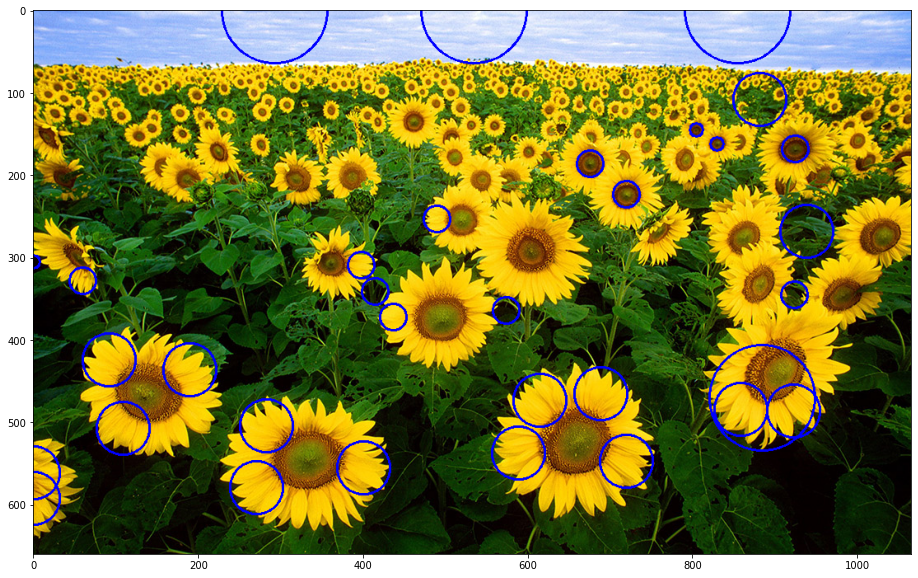

In [12]:
im_copy = color_im.copy()
for i in range(np.sum(blobs)):
    cv2.circle(img=im_copy, center=centers[i, [-1, 0]], radius=radius[i], color=(0, 0, 255), thickness=2)
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(im_copy);

In [13]:
np.min(np.argwhere(blobs)[:, 0]), np.max(np.argwhere(blobs)[:, 0])

(1, 4)

### 4. Image transformation

In [14]:
def transformIm(im, theta, s):
    """Return a scaled and rotated version of the original image im."""
    r, c = im.shape[:2]
    M = cv2.getRotationMatrix2D(((c - 1) / 2, (r - 1) / 2), theta, s)
    r_im = cv2.warpAffine(im, M, (c,r))
    return r_im

In [15]:
im2 = transformIm(im, 30, 0.7)
color_im2 = transformIm(color_im, 30, 0.7)

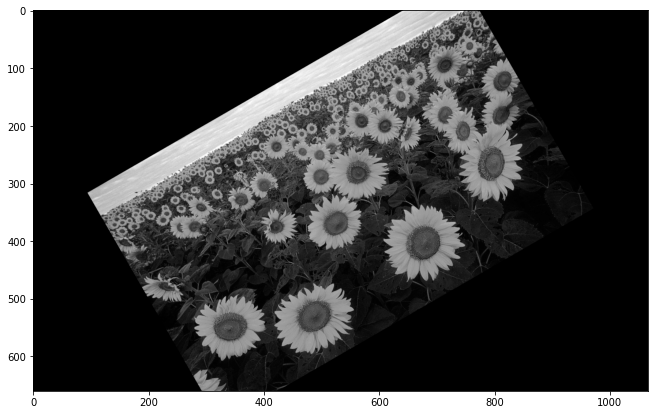

In [16]:
fig, ax = plt.subplots(1, figsize=(20, 7))
ax.imshow(im2, cmap="gray");

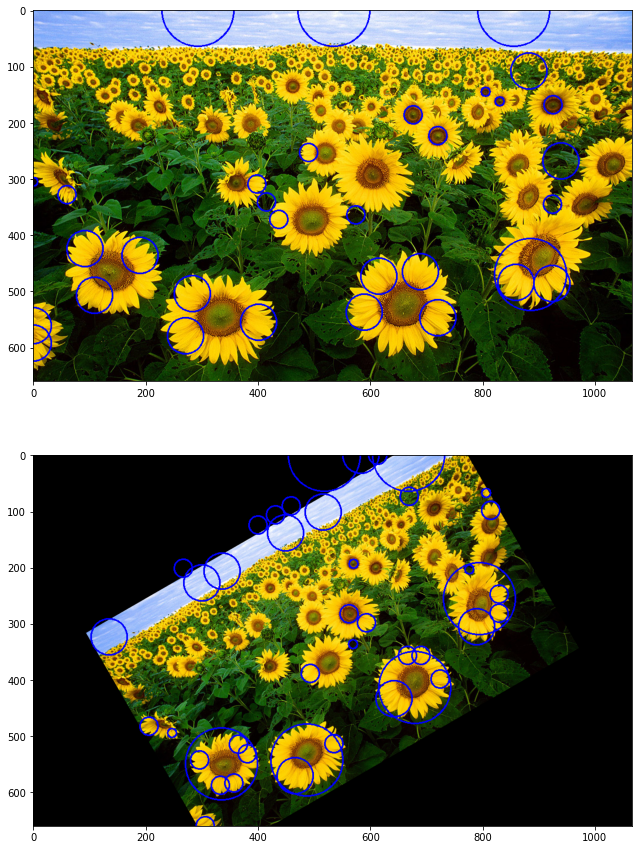

In [17]:
blobs = detectBlobs(im2, sigma, n, threshold=0.12, order=10)
centers = np.argwhere(blobs)[:, 1:]

DoGs = differenceOfGaussian(im=im, sigma=sigma, n=n)
radius= (2 ** np.argwhere(blobs)[:, 0] * sigma).astype(int)

im2_copy = color_im2.copy()
for i in range(np.sum(blobs)):
    cv2.circle(img=im2_copy, center=centers[i, [-1, 0]], radius=radius[i], color=(0, 0, 255), thickness=2)
fig, ax = plt.subplots(2, figsize=(30, 15))
ax[0].imshow(im_copy, cmap="gray");
ax[1].imshow(im2_copy, cmap="gray");

## Using SIFT features

### 5. Matching descriptors

In [18]:
im1 = (im  * 255).astype('uint8')
im2 = (im2 * 255).astype('uint8')

In [19]:
sift = cv2.SIFT_create(
    nfeatures = 100,
    nOctaveLayers = 5, # Octave layer in DoG - automatically computed
    contrastThreshold = 0.04, #Filter out weak features in semi-uniform regions. The larger the threshold, the less features are produced by the detector.
    edgeThreshold = 10000, # Filter out edge-like features. The larger this Threshold, the less features are filtered out. 
    sigma = 2
)
keypoint1, descriptor1 = sift.detectAndCompute(im1, None)
keypoint2, descriptor2 = sift.detectAndCompute(im2, None)

In [20]:
bf = cv2.BFMatcher()
matches = bf.match(descriptor1, descriptor2)

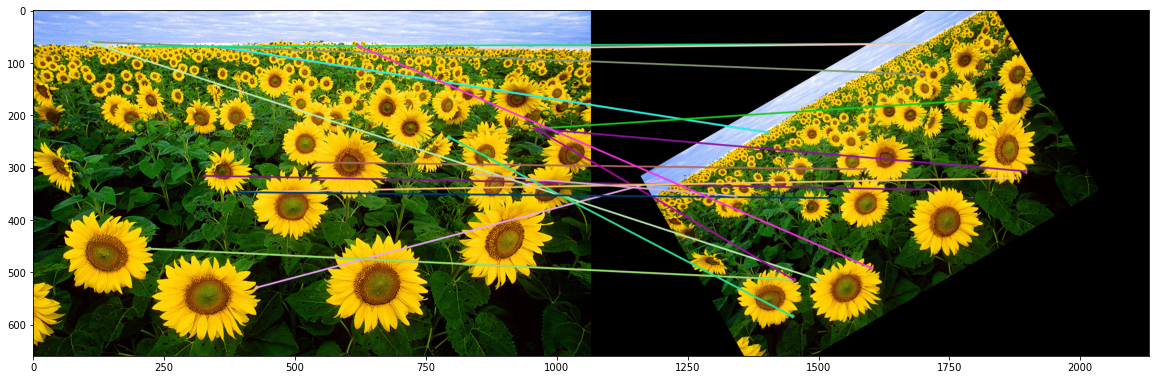

In [21]:
# sorted_matches = sorted(matches_1, key = lambda x:x.distance)

img3 = cv2.drawMatches(
    color_im, keypoint1,
    color_im2, keypoint2,
    matches[:20],
#     sorted_matches[:40],
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=2
)
plt.figure(figsize = (20,20))
plt.imshow(img3);

In [22]:
matches_2 = bf.knnMatch(descriptor1, descriptor2, k=2)
distinctive = []
for m, n in matches_2:
    if m.distance < 0.7 * n.distance:
        distinctive.append(m)
print(f"There are {len(distinctive)} distinctive matches.")

There are 35 distinctive matches.


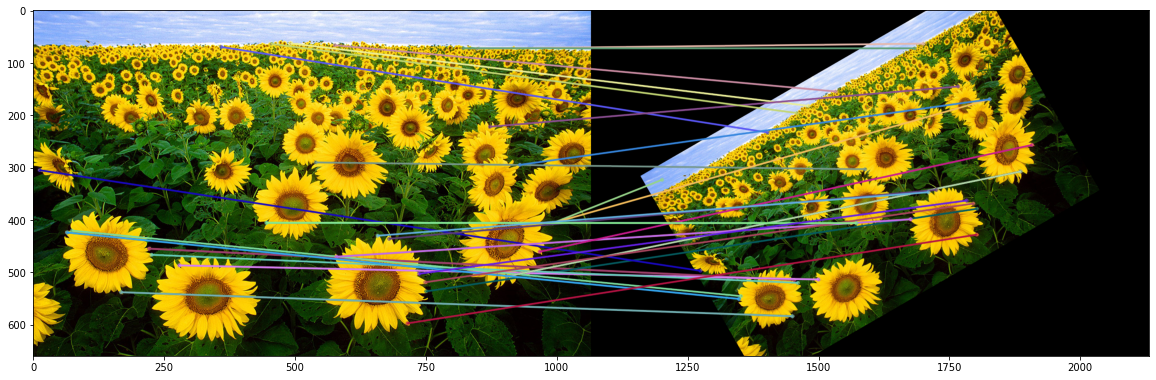

In [23]:
im3 = cv2.drawMatches(
    color_im, keypoint1,
    color_im2, keypoint2,
    distinctive,
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=2
)
plt.figure(figsize = (20,20))
plt.imshow(im3);

### 6. Test on real images

In [27]:
imr1_color = cv2.imread("data/notebook1.jpg")[:, :, [2, 1, 0]]
imr2_color = cv2.imread("data/notebook2.jpg")[:, :, [2, 1, 0]]

imr1 = (np.sum(imr1_color, axis=2) // 3).astype("uint8")
imr2 = (np.sum(imr2_color, axis=2) // 3).astype("uint8")

There are 106 distinctive matches.


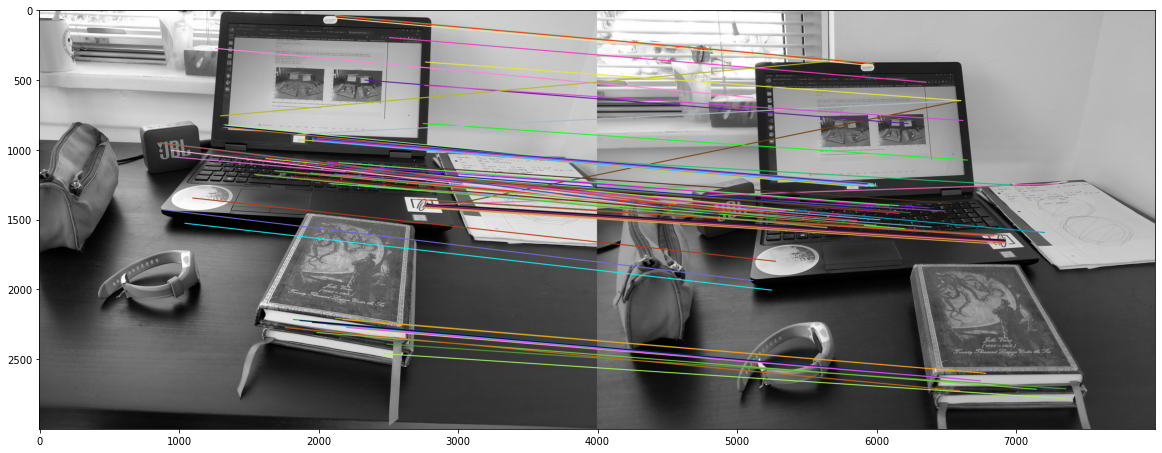

In [28]:
sift = cv2.SIFT_create(
    nfeatures = 1000,
    nOctaveLayers = 5, # Octave layer in DoG - automatically computed
    contrastThreshold = 0.04, #Filter out weak features in semi-uniform regions. The larger the threshold, the less features are produced by the detector.
    edgeThreshold = 10000, # Filter out edge-like features. The larger this Threshold, the less features are filtered out. 
    sigma = 1.6
)
keypoint1, descriptor1 = sift.detectAndCompute(imr1, None)
keypoint2, descriptor2 = sift.detectAndCompute(imr2, None)

matches_2 = bf.knnMatch(descriptor1, descriptor2, k=2)
distinctive = []
for m, n in matches_2:
    if m.distance < 0.7 * n.distance:
        distinctive.append(m)
print(f"There are {len(distinctive)} distinctive matches.")

im3 = cv2.drawMatches(
    imr1, keypoint1,
    imr2, keypoint2,
    distinctive,
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=5
)
plt.figure(figsize = (20,20))
plt.imshow(im3);

There are 66 distinctive matches.


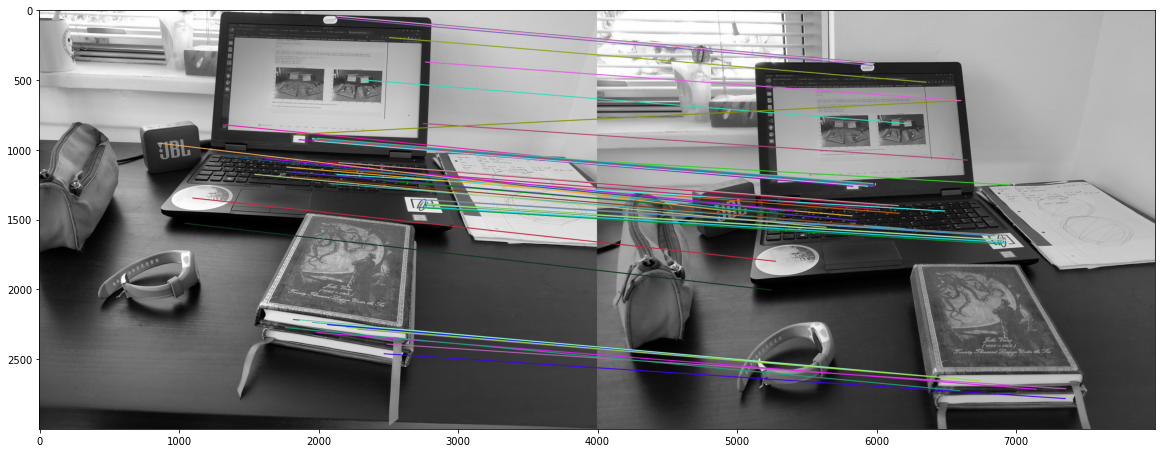

In [30]:
distinctive = []
for m, n in matches_2:
    if m.distance < 0.6 * n.distance:
        distinctive.append(m)
print(f"There are {len(distinctive)} distinctive matches.")

im3 = cv2.drawMatches(
    imr1, keypoint1,
    imr2, keypoint2,
    distinctive,
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=5
)
plt.figure(figsize = (20,20))
plt.imshow(im3);